NN from scratch on MNIST dataset Kaggle Competition

In [47]:
import numpy as np 
import pandas as pd
import os
from matplotlib import pyplot as plt

Load Data, Preprocessing

In [48]:
data = pd.read_csv('kaggle/input/train.csv')

data.head()

data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.

_,m_train = X_train.shape


In [49]:
X_train[:, 0].shape
Y_train

array([5, 2, 7, ..., 0, 5, 2])

In [50]:
def init_params():
    W1 = np.random.normal(size=(64, 784)) * np.sqrt(1./784)
    b1 = np.random.normal(size=(64, 1)) * np.sqrt(1./64)
    W2 = np.random.normal(size=(32, 64)) * np.sqrt(1./64)
    b2 = np.random.normal(size=(32, 1)) * np.sqrt(1./32)
    W3 = np.random.normal(size=(16, 32)) * np.sqrt(1./32)  # Adjusting for an additional layer
    b3 = np.random.normal(size=(16, 1)) * np.sqrt(1./16)
    W4 = np.random.normal(size=(10, 16)) * np.sqrt(1./16)  # Corrected for final output
    b4 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    return W1, b1, W2, b2, W3, b3, W4, b4

def ReLU(Z):
    return np.maximum(0, Z)

def deriv_ReLU(Z):
    return Z > 0

def softmax(Z):
    A =  np.exp(Z) / sum(np.exp(Z))
    return A

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, int(Y.max()) + 1))
    one_hot_Y[np.arange(Y.size), Y.astype(int)] = 1
    # each row is an example, so we want one column to be ex.
    one_hot_Y = one_hot_Y.T
    return one_hot_Y


def forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    Z3 = W3.dot(A2) + b3
    A3 = ReLU(Z3)
    Z4 = W4.dot(A3) + b4
    A4 = softmax(Z4)
    return Z1, A1, Z2, A2, Z3, A3, Z4, A4

def back_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, W1, W2, W3, W4, X, Y):
    one_hot_Y = one_hot(Y)

    dZ4 = A4 - one_hot_Y
    dW4 = 1 / m * dZ4.dot(A3.T)
    db4 = 1 / m * np.sum(dZ4, axis=1, keepdims=True)

    dA3 = W4.T.dot(dZ4)
    dZ3 = dA3 * deriv_ReLU(Z3)
    dW3 = 1 / m * dZ3.dot(A2.T)
    db3 = 1 / m * np.sum(dZ3, axis=1, keepdims=True)

    dA2 = W3.T.dot(dZ3)
    dZ2 = dA2 * deriv_ReLU(Z2)
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1, keepdims=True)

    dA1 = W2.T.dot(dZ2)
    dZ1 = dA1 * deriv_ReLU(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2, dW3, db3, dW4, db4

def update_params(W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4, alpha):
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    W3 -= alpha * dW3
    b3 -= alpha * db3
    W4 -= alpha * dW4
    b4 -= alpha * db4
    return W1, b1, W2, b2, W3, b3, W4, b4

In [51]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size



def gradient_descent(X, Y, iterations, alpha):
    W1, b1, W2, b2, W3, b3, W4, b4 = init_params()
    accuracies = []
    iteration_steps = []
    
    for i in range(iterations):
        # Updated for an additional forward propagation step
        Z1, A1, Z2, A2, Z3, A3, Z4, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X)
        # Updated for an additional backward propagation step
        dW1, db1, dW2, db2, dW3, db3, dW4, db4 = back_prop(Z1, A1, Z2, A2, Z3, A3, Z4, A4, W1, W2, W3, W4, X, Y)
        # Updated for additional parameters update step
        W1, b1, W2, b2, W3, b3, W4, b4 = update_params(W1, b1, W2, b2, W3, b3, W4, b4, dW1, db1, dW2, db2, dW3, db3, dW4, db4, alpha)

        if i % 20 == 0 or i == iterations - 1:
            # Use A3 for predictions since it's the output of the last layer
            predictions = get_predictions(A4)
            acc = get_accuracy(predictions, Y)
            print("Iteration: ", i)
            print("Accuracy: ", acc)
            accuracies.append(acc)
            iteration_steps.append(i)

    # Return the parameters including those for the third layer
    return W1, b1, W2, b2, W3, b3, W4, b4, accuracies

In [52]:
alphas = [0.15, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0001]  # alpha values to train with.
best_accuracy = 0
best_params = {}
alpha_accuracies = {}  # To store accuracies for each alpha training session

for alpha in alphas:
    W1, b1, W2, b2, W3, b3, W4, b4, accuracies = gradient_descent(X_train, Y_train, 100, alpha)
    alpha_accuracies[alpha] = accuracies
    final_accuracy = accuracies[-1]  # The final accuracy for this alpha

    if final_accuracy > best_accuracy:
        best_accuracy = final_accuracy
        best_params = {
            'W1': W1, 'b1': b1,
            'W2': W2, 'b2': b2,
            'W3': W3, 'b3': b3,
            'W4': W4, 'b4': b4,
            'alpha': alpha,
            'accuracy': best_accuracy
        }

[0 0 0 ... 0 0 0] [5 2 7 ... 0 5 2]
Iteration:  0
Accuracy:  0.09839024390243903
[0 9 7 ... 0 4 2] [5 2 7 ... 0 5 2]
Iteration:  20
Accuracy:  0.4128780487804878
[0 9 7 ... 0 3 2] [5 2 7 ... 0 5 2]
Iteration:  40
Accuracy:  0.6660731707317074
[2 4 7 ... 0 3 2] [5 2 7 ... 0 5 2]
Iteration:  60
Accuracy:  0.7433414634146341
[2 9 7 ... 0 3 2] [5 2 7 ... 0 5 2]
Iteration:  80
Accuracy:  0.7638048780487805
[2 4 7 ... 0 5 2] [5 2 7 ... 0 5 2]
Iteration:  99
Accuracy:  0.8199024390243902
[6 6 6 ... 6 6 6] [5 2 7 ... 0 5 2]
Iteration:  0
Accuracy:  0.05873170731707317
[6 9 7 ... 6 6 6] [5 2 7 ... 0 5 2]
Iteration:  20
Accuracy:  0.2995609756097561
[6 2 7 ... 6 6 6] [5 2 7 ... 0 5 2]
Iteration:  40
Accuracy:  0.35736585365853657
[6 0 7 ... 0 6 6] [5 2 7 ... 0 5 2]
Iteration:  60
Accuracy:  0.4554878048780488
[2 0 7 ... 0 2 6] [5 2 7 ... 0 5 2]
Iteration:  80
Accuracy:  0.5498780487804878
[2 0 7 ... 0 2 2] [5 2 7 ... 0 5 2]
Iteration:  99
Accuracy:  0.6632439024390244
[3 3 3 ... 3 3 3] [5 2 7 ..

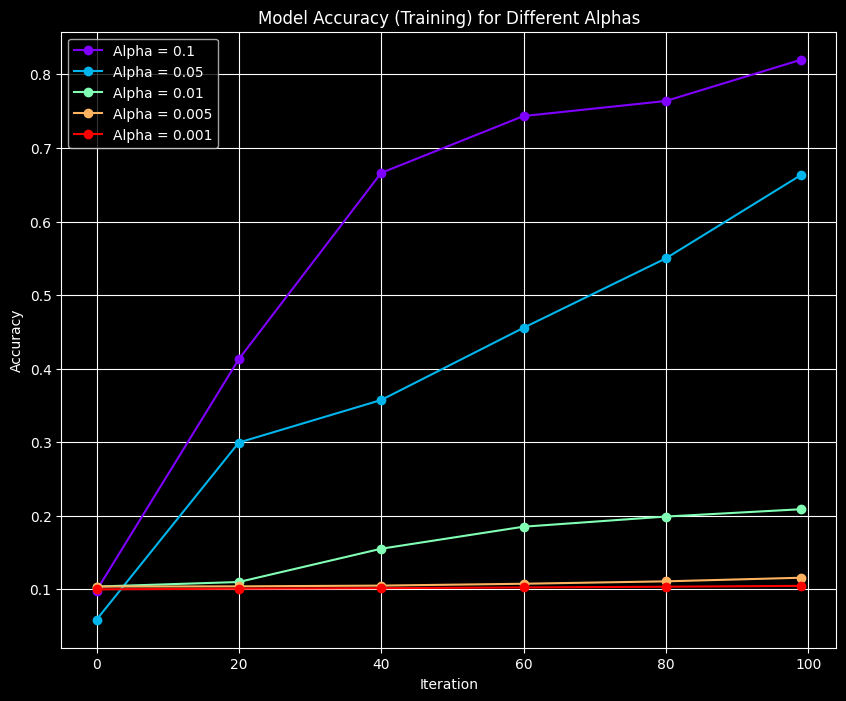

In [53]:
iteration_steps = np.arange(0, 100, 20).tolist() + [99]  # Adjust based on your actual iteration logging
plt.figure(figsize=(10, 8))
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(alphas))))

for alpha, accuracies in alpha_accuracies.items():
    plt.plot(iteration_steps, accuracies, marker='o', color=next(colors), label=f'Alpha = {alpha}')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Model Accuracy (Training) for Different Alphas')
plt.legend()
plt.grid(True)
plt.show()

In [64]:
def make_predictions(X, W1, b1, W2, b2, W3, b3, W4, b4):
    # Ensure forward_prop processes through all four layers, using the output from the fourth layer
    _, _, _, _, _, _, _, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X)
    predictions = get_predictions(A4)  # Use A4, the output of the last layer
    return predictions


def test_prediction(index, W1, b1, W2, b2, W3, b3, W4, b4, X_train, Y_train):
    current_image = X_train[:, index, None]
    # Correction: Ensure you pass all parameters for the four layers
    prediction = make_predictions(current_image, W1, b1, W2, b2, W3, b3, W4, b4)
    label = Y_train[index]
    print("Prediction:", prediction)
    print("Label:", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.title(f'Predicted: {prediction}, Actual: {label}')
    plt.show()

# Example of how to call test_prediction
# test_prediction(0, *best_params, X_train, Y_train)
    

Prediction: [3]
Label: 5


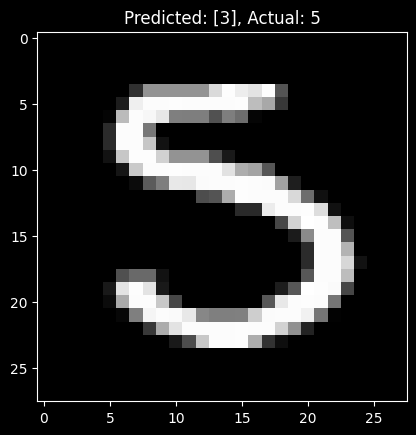

In [69]:
test_prediction(0, best_params['W1'], best_params['b1'], best_params['W2'], best_params['b2'], 
                best_params['W3'], best_params['b3'], best_params['W4'], best_params['b4'], 
                X_train, Y_train)

In [73]:

test_predictions = make_predictions(X_test, best_params['W1'], best_params['b1'], best_params['W2'], best_params['b2'], 
                best_params['W3'], best_params['b3'], best_params['W4'], best_params['b4'])

get_accuracy(test_predictions, Y_test)

[9 7 9 3 6 1 4 4 9 3 3 0 7 7 4 9 3 9 1 1 2 3 3 7 8 9 1 9 7 7 6 1 4 1 7 3 1
 9 5 4 3 1 6 3 0 0 3 5 7 0 3 2 0 3 0 5 6 5 7 3 0 1 0 3 2 7 1 7 5 3 1 6 8 5
 7 4 6 3 3 8 2 2 3 3 0 0 1 9 7 1 8 5 1 9 6 7 1 1 8 1 2 9 9 0 9 9 9 6 9 7 1
 9 8 4 7 7 3 7 9 3 3 0 4 6 7 1 9 0 0 2 8 5 0 9 0 2 3 5 3 9 2 1 9 3 4 9 5 2
 3 6 6 6 6 8 5 5 0 1 9 0 6 6 7 1 9 3 5 4 4 8 9 9 3 3 1 6 9 0 9 7 3 5 9 3 5
 3 6 7 9 3 9 0 1 6 3 2 8 8 7 3 0 8 0 6 3 1 6 0 4 9 3 7 9 1 5 1 0 9 3 3 7 9
 5 4 7 8 0 2 6 7 3 5 7 5 7 2 6 0 3 8 3 7 4 3 9 7 8 6 4 5 1 6 1 3 5 3 6 7 1
 1 3 3 0 3 6 0 3 3 7 6 8 9 3 0 6 9 3 4 0 5 3 1 7 5 3 6 5 4 7 0 1 8 4 3 9 6
 8 7 7 2 9 4 5 5 4 1 7 9 5 5 9 7 9 8 2 0 0 1 4 2 3 2 1 1 4 9 1 5 7 9 3 9 9
 9 7 4 3 9 0 4 3 6 3 9 1 3 9 3 4 0 0 9 2 1 5 1 2 7 8 1 3 3 5 4 7 3 9 3 0 0
 6 9 7 3 9 3 4 9 7 9 6 8 9 4 6 4 9 3 1 5 6 6 6 1 4 2 7 5 0 0 4 3 6 9 5 3 4
 1 3 9 3 2 2 1 7 0 3 2 3 1 0 6 7 8 1 6 6 0 8 2 6 0 5 3 3 3 3 9 8 2 3 0 1 0
 0 1 2 7 1 9 5 7 9 7 2 5 0 1 0 1 9 8 9 7 3 3 7 1 0 9 4 6 6 0 6 3 7 9 0 9 8
 1 7 1 8 7 6 3 9 3 1 9 3 

0.791

In [74]:
test_data_df = pd.read_csv('kaggle/input/test.csv')
test_data_df.head()


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
# Convert to NumPy array for numerical operations
test_data_np = np.array(test_data_df)

# There's no need to transpose the test data since we're not adding a bias row to it
# Normalize the pixel values
X_test_preprocessed = test_data_np / 255.
X_test_preprocessed = X_test_preprocessed.T

# Now, make predictions with the correctly shaped test data
print("Shape of X_test_preprocessed:", X_test_preprocessed.shape)
X_test_preprocessed[:, 0].shape

test_predictions_output = make_predictions(X_test_preprocessed, best_params['W1'], best_params['b1'], best_params['W2'], best_params['b2'], 
                best_params['W3'], best_params['b3'], best_params['W4'], best_params['b4'])
submission_df = pd.DataFrame({
    'ImageId' : range(1, len(test_predictions_output) + 1),
    'Label' : test_predictions
})

submission_df.to_csv('my_submission.csv', index = False)

Shape of X_test_preprocessed: (784, 28000)


ValueError: All arrays must be of the same length